In [ ]:
Name = "Luisa Danalachi"
Matriculation_Number = "7022909"

Name = "Victor Martinez Palomares"
Matriculation_Number = "7021729"

Name = "Soham Roy"
Matriculation_Number = "7028704"

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!mkdir ./datasets
!mkdir ./datasets/lyme_dataset
!cp -r drive/MyDrive/Colab\ Notebooks/HLCV_project/datasets/lyme_dataset.zip ./datasets
!unzip -q -o "./datasets/lyme_dataset.zip" -d "./datasets/lyme_dataset"

'''
!mkdir ./resources


!cp -r drive/MyDrive/Colab\ Notebooks/HLCV/Exercise_3/resources/fig1.png ./resources
!cp -r drive/MyDrive/Colab\ Notebooks/HLCV/Exercise_3/resources/fig2.png ./resources

'''

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'\n!mkdir ./resources\n\n\n!cp -r drive/MyDrive/Colab\\ Notebooks/HLCV/Exercise_3/resources/fig1.png ./resources\n!cp -r drive/MyDrive/Colab\\ Notebooks/HLCV/Exercise_3/resources/fig2.png ./resources\n\n'

In [2]:
import os
import glob
import random
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.io import read_image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image





### Params

In [3]:
IMAGE_SIZE = 256
EPOCHS = 120
BATCH = 8
LR = 1e-4

path = "./datasets/lyme_dataset/RashData"


#--------------------------------
# Device configuration
#--------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: %s'%device)


Using device: cuda


### Loading fine-tuning dataset

In [4]:
def load_data(path, train=True):
  if train:
    # load train data
    images = sorted(Path(os.path.join(path, "Train/Train_2_Cases/Lyme_Negative")).glob('**/*'))
    #images = sorted(glob(os.path.join(path, "Train/Train_2_Cases/Lyme_Negative/*")))
    masks = np.zeros(len(images), dtype="float32")
    images1 = sorted(Path(os.path.join(path, "Train/Train_2_Cases/Lyme_Positive")).glob('**/*'))
    #images1 = (sorted(glob(os.path.join(path, "Train/Train_2_Cases/Lyme_Positive/*"))))
    images = images + images1
    masks = np.concatenate([masks,np.ones(len(images1), dtype="float32")])
    total_size = len(images)
    dataset = list(zip(images, masks))
    random.shuffle(dataset)
    '''
    # split train/val data
    val_size = int(split * len(dataset))
    train_size = len(dataset) - val_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    '''
    # unzip train data
    images, masks = zip(*dataset)
    #train_x = list(images)
    train_x = list(map(str, images))
    train_y = np.array(list(masks))

    return train_x, train_y
  else:
    # load test data
    images = sorted(Path(os.path.join(path, "Validation/Validation_2_Cases/Lyme_Negative")).glob('**/*'))
    #images = sorted(glob(os.path.join(path, "Validation/Validation_2_Cases/Lyme_Negative/*")))
    masks = np.zeros(len(images), dtype="float32")
    images1 = sorted(Path(os.path.join(path, "Validation/Validation_2_Cases/Lyme_Positive")).glob('**/*'))
    #images1 = (sorted(glob(os.path.join(path, "Validation/Validation_2_Cases/Lyme_Positive/*"))))
    images = images + images1
    masks = np.concatenate([masks,np.ones(len(images1), dtype="float32")])

    c = list(zip(images, masks))
    random.shuffle(c)
    images, masks = zip(*c)

    #test_x = list(images)
    test_x = list(map(str, images))
    test_y = np.array(list(masks))

    #train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=42)
    #train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=42)
    
    return test_x, test_y

In [5]:
train_x, train_y = load_data(path, train=True)
print("Training data: ", (train_x))
print(len(train_x))
test_x, test_y = load_data(path, train=False)
print("Testing data: ", (test_x))
print(len(test_x))

Training data:  ['datasets/lyme_dataset/RashData/Train/Train_2_Cases/Lyme_Positive/erythema migrans94.jpg', 'datasets/lyme_dataset/RashData/Train/Train_2_Cases/Lyme_Positive/erythema migrans248.jpg', 'datasets/lyme_dataset/RashData/Train/Train_2_Cases/Lyme_Negative/Pityriasis rosea rash104.jpg', 'datasets/lyme_dataset/RashData/Train/Train_2_Cases/Lyme_Negative/ringworm54.jpg', 'datasets/lyme_dataset/RashData/Train/Train_2_Cases/Lyme_Positive/erythema migrans259.jpg', 'datasets/lyme_dataset/RashData/Train/Train_2_Cases/Lyme_Negative/fixed drug reaction31.jpg', 'datasets/lyme_dataset/RashData/Train/Train_2_Cases/Lyme_Positive/erythema migrans57.jpg', 'datasets/lyme_dataset/RashData/Train/Train_2_Cases/Lyme_Negative/ringworm74.jpg', 'datasets/lyme_dataset/RashData/Train/Train_2_Cases/Lyme_Negative/Pityriasis rosea rash103.jpg', 'datasets/lyme_dataset/RashData/Train/Train_2_Cases/Lyme_Positive/erythema migrans125.jpg', 'datasets/lyme_dataset/RashData/Train/Train_2_Cases/Lyme_Negative/ringw

In [6]:

class LymeDataset(Dataset):
  def __init__(self, img_dir, train=True, transform=None):
    '''
    Args:
    root_dir (string): Directory with all the images.
    transform (callable, optional): Optional transform to be applied
      on a sample.
    '''
    self.train = train
    self.img_dir = img_dir
    self.transform = transform
    self.images_path, self.labels = load_data(img_dir, train)
  

  def __len__(self) -> int:
    return len(self.labels)

  def __getitem__(self, idx):
    img_path = self.images_path[idx]
    image = Image.open(img_path).convert('RGB')
    #image = read_image(img_path)
    label = self.labels[idx]
    if self.transform:
      image = self.transform(image)
    return image, label

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


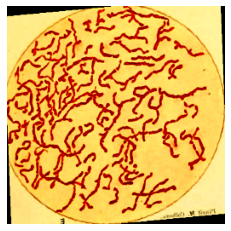

In [7]:
# Define augmentations and create dataloader

# Now
#import torch
#torch.manual_seed(17)
data_aug_transforms = []
data_aug_transforms.append(transforms.RandomRotation([-90, 90]) ) # geometric
data_aug_transforms.append( transforms.RandomHorizontalFlip() )  # geometric
data_aug_transforms.append(transforms.ColorJitter(brightness = 0.2)) # brightness
norm_transforms = [transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
train_transforms = transforms.Compose(data_aug_transforms + norm_transforms)
test_transforms = norm_transforms
train_val_dataset = LymeDataset(img_dir=path, train=True, transform=train_transforms)
test_dataset = LymeDataset(img_dir=path, train=False, transform=test_transforms)


# Draw the image being a tensor
image, label = train_val_dataset[0]
#plt.imshow(torch.reshape(image, (-1,)))
plt.imshow(image.permute(1, 2, 0))

plt.axis('off')

plt.show()


In [8]:
#-------------------------------------------------
# Prepare the training and validation splits
#-------------------------------------------------
'''
  # split train/val data
  val_size = int(split * len(dataset))
  train_size = len(dataset) - val_size
  train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
  '''
val_split = 0.1
num_training = int((1 - val_split) * len(train_val_dataset))
num_validation = len(train_val_dataset) - num_training
mask = list(range(num_training))
train_dataset = torch.utils.data.Subset(train_val_dataset, mask)
mask = list(range(num_training, num_training + num_validation))
val_dataset = torch.utils.data.Subset(train_val_dataset, mask)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True, drop_last=True)


print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

print(len(train_dataloader))
print(len(val_dataloader))
print(len(test_dataloader))


321
36
87
80
9
21


In [ ]:
'''


for i_batch, batch in enumerate(train_dataloader):
  fig, ax_array = plt.subplots(10, 10,squeeze=False)
  for i,ax_row in enumerate(ax_array):
    for j,axes in enumerate(ax_row):
        axes.set_title('{},{}'.format(i,j))
        axes.set_yticklabels([])
        axes.set_xticklabels([])
        image = batch[0][i*10+j]
        axes.imshow(image.permute(1, 2, 0))
plt.show()
'''
'''

    # Draw the image being a tensor
    image= batch[0][0]
    label = batch[1][0]
    #ax0.imshow(torch.reshape(image, (-1,)))
    plt.imshow(image.permute(1, 2, 0))

    plt.axis('off')

    plt.show()
'''

"\n\n    # Draw the image being a tensor\n    image= batch[0][0]\n    label = batch[1][0]\n    #ax0.imshow(torch.reshape(image, (-1,)))\n    plt.imshow(image.permute(1, 2, 0))\n\n    plt.axis('off')\n\n    plt.show()\n"

### Create Model

In [9]:
from torchvision import models
#from torchvision.models import ResNet50_Weights

layer_config= [2048, 512, 256]
num_classes = 1
num_epochs = 30
batch_size = 200
learning_rate = 1e-5
learning_rate_decay = 0.99

# Create ResNet 50 model pretrained with ImageNet
class ResNet50(nn.Module):
    def __init__(self, n_class, fine_tune, pretrained=True):
        super(ResNet50, self).__init__()
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        #weights = None
        #if pretrained:
        #  weights = ResNet50_Weights.DEFAULT
        self.net = models.resnet50(pretrained=pretrained)
        # get rid of average pooling
        #self.net.avgpool = nn.Identity() 
        # disable gradients for the network
        # set_parameter_requires_grad(self.net.features, fine_tune)
        # add new classifier layers
        self.net.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(layer_config[0], layer_config[1]),
            nn.BatchNorm1d(layer_config[1]),
            nn.ReLU(),
            nn.Linear(layer_config[1], layer_config[2]),
            nn.BatchNorm1d(layer_config[2]),
            nn.ReLU(),
            nn.Linear(layer_config[2], n_class)
        )       
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    def forward(self, x):
        #################################################################################
        # TODO: Implement the forward pass computations                                 #
        #################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        out = self.net(x)
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return out.view(-1, 1).squeeze(1).type(torch.FloatTensor) 

# Initialize the model for this run
fine_tune = True
pretrained = True
model= ResNet50(num_classes, fine_tune, pretrained)
print(model)


#################################################################################
# TODO: Only select the required parameters to pass to the optimizer. No need to#
# update parameters which should be held fixed (conv layers).                   #
#################################################################################
print("Params to learn:")
if fine_tune:
    params_to_update = []
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    for name, param in model.named_parameters():
      if param.requires_grad == True:
          params_to_update.append(param)
          print("\t",name)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
else:
    params_to_update = model.parameters()
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)


model.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet50(
  (net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0)

ResNet50(
  (net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0)

In [11]:
CUDA_LAUNCH_BLOCKING="1"


def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# store best model and acc
best_model_name = 'bestmodel_resnet50_imagenet.ckpt'
best_model = None
best_val_acc = 0.


loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params_to_update, lr=learning_rate)
# Train the model
lr = learning_rate
total_step = len(train_dataloader)
for epoch in range(num_epochs):
    correct = 0
    total = 0 
    for i, (images, labels) in enumerate(train_dataloader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images).to(device)
        predicted = torch.where(torch.sigmoid(outputs.data) > 0.5, 1, 0)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 10 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Train accuracy is: {} %'.format(100 * correct / total))
    train_acc_history.append(100 * correct / total)
    loss_history.append(loss.item())
    # Code to update the lr
    lr *= learning_rate_decay
    update_lr(optimizer, lr)
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
            outputs = model(images).to(device)

            predicted = torch.where(torch.sigmoid(outputs.data) > 0.5, 1, 0)
            loss = criterion(outputs, labels)
            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            print("total: ", total)
            print("correct: ", correct)
        #################################################################################
        # TODO: Q2.b Use the early stopping mechanism from previous questions to save   #
        # the model which has acheieved the best validation accuracy so-far.            #
        #################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        val_accuracy = 100 * correct / total
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_model = model
            print("New best validation accuracy: {} %".format(best_val_acc))
            # save model with best accuracy
            #torch.save(best_model.state_dict(), best_model_name)
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


        print('Validataion accuracy is: {} %'.format(100 * correct / total))
        val_acc_history.append(val_accuracy)
        val_loss_history.append(loss.item())
  
# plot the accuracy history
plt.plot(train_acc_history)
plt.plot(val_acc_history)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy history')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

# plot the loss history
plt.plot(loss_history)
plt.plot(val_loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss history')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

Epoch [4/30], Step [20/80], Loss: 0.4164
Epoch [4/30], Step [30/80], Loss: 0.4320
Epoch [4/30], Step [40/80], Loss: 0.7852
Epoch [4/30], Step [50/80], Loss: 0.4930


KeyboardInterrupt: ignored

### Extra code

In [ ]:
'''
def tf_parse(x,y):
  def _parse(x,y):
      x = read_image(x)
      return x,y

  x,y = tf.numpy_function(_parse, [x,y],  [tf.float64, tf.float64])
  #y = tf.cast(y, tf.double)
  x.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
  #x = tf.cast(x, tf.double)
  return x,y

def tf_dataset(x, y, batch=8):
  dataset = tf.data.Dataset.from_tensor_slices((x,y))
  dataset = dataset.map(tf_parse)
  #print(dataset)
  dataset = dataset.map(data_augmentation)
  dataset = dataset.batch(batch)
  dataset = dataset.repeat()
  return dataset

train_dataset = tf_dataset(train_x, train_y, batch=BATCH)
valid_dataset = tf_dataset(valid_x, valid_y, batch=BATCH)
'''

In [ ]:
images= np.zeros(20)
labels = np.ones(20)
data = list(zip(images,labels))
print(len(data))
print(data)
print(data.shape)